# Import Libraries

In [1]:
# import web driver
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from seleniumrequests import Chrome

from bs4 import BeautifulSoup
import requests
import time
import random
import re
import getpass
import os
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score


%matplotlib inline 

# Crime Data - Clean and Aggregate

#### Clean Crime Data and Save to 'chicago_crime_cleaned_aggregated.csv'

In [2]:
# # Preprocessing Chicago Crime Data

# # Import Chicago Crime Data : Source : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
# df_crime = pd.read_csv("chicago_crime.csv")

# # Convert text date to datetime
# df_crime['DATE_TIME'] = pd.to_datetime(df_crime['Date'],format="%m/%d/%Y %I:%M:%S %p", errors = 'coerce')

# # Strip hr, min, sec data so that aggregation per day is possible
# df_crime['DATE_TIME_TRUN'] = df_crime['DATE_TIME'].map(lambda x: x.strftime('%Y-%m-%d'))

# # Drop unneeded columns
# df_crime = df_crime[['ID','DATE_TIME_TRUN']].copy()

# # Just get the date and total crime count and create new df after aggregating by single day
# df_crime = df_crime.groupby(['DATE_TIME_TRUN'],as_index = False).count().copy()

# # Save cleaned data
# with open('chicago_crime_cleaned_aggregated.pkl', 'wb') as picklefile:
#     pickle.dump(df_crime, picklefile)


#### Load Cleaned & Aggregated Crime Data and Few More Tweaking

In [3]:
# # Load data
# with open('chicago_crime_cleaned_aggregated.pkl', 'rb') as picklefile: 
#     df_crime = pickle.load(picklefile)

# # Turn DATE_TIME back to datetime dtype
# df_crime['DATE_TIME'] = pd.to_datetime(df_crime['DATE_TIME_TRUN'])
# df_crime['YEAR_MONTH'] = df_crime['DATE_TIME_TRUN'].apply(lambda x:x[:-3])

# # Remove Crime Data Outside Available Weather Data
# df_crime = df_crime[df_crime['DATE_TIME_TRUN']>'2009-09-01'] 

# # Rename Columns to Make Them More Intuitive and for Later Merging with Weather Data
# df_crime.rename(columns={'ID':'CRIME_COUNT','DATE_TIME':'DATE_TIME_PROCESSED'}, inplace=True)

# Weather Data -  Scraping

#### (Testing) scroll length 

In [4]:
# url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(2,2010)
# driver.get(url) 
# # Load Entire Page by Scrolling to charts
# SCROLL_PAUSE_TIME = 2# Scroll to Very Bottom to Load All
# driver.execute_script("window.scrollTo(0, document.body.scrollHeight/4);") # Scroll down to bottom

#### Web scraping function

In [5]:
# def scrape_weather_url(url):
#     # weather data holder to be inserted to pandas dataframe
#     high_low, weather_desc, humidity_barometer, wind, date_time = [], [], [], [], []
    
#     # open url
#     driver.get(url)
#     soup = BeautifulSoup(driver.page_source, "lxml")
#     days_chain = [x.find_all('a') for x in soup.find_all(class_='weatherLinks')]
#     time.sleep(5)
    
#     # Load Entire Page by Scrolling to charts
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight/3.5);") # Scroll down to bottom
    
#     # First load of each month takes extra long time. Therefore 'counter' variable is used to run else block first
#     counter = 0
#     for ix,link in enumerate(days_chain[0]):
        
#         '''
#         Bottom section tries to solve loading issue by implementing wait feature
#         Refer : https://selenium-python.readthedocs.io/waits.html
#         '''
#         wait = WebDriverWait(driver, 10)
#         if counter!=0:
#             delay = 3 # seconds
#             try:
#                 myElem = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'weatherLinks')))
#             except TimeoutException:
#                 print("Loading took too much time!" ) 
#             day_link = driver.find_element_by_xpath("//div[@class='weatherLinks']/a[{}]".format(ix+1))
#             wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='weatherLinks']/a[{}]".format(ix+1))))
#             day_link.click()
#         else:
#             delay = 5 # seconds
#             try:
#                 myElem = WebDriverWait(driver, delay).until(EC.presence_of_element_located((By.CLASS_NAME, 'weatherLinks')))
#             except TimeoutException:
#                 print("Loading took too much time!" ) 
#             day_link = driver.find_element_by_xpath("//div[@class='weatherLinks']/a[{}]".format(ix+1))
#             wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='weatherLinks']/a[{}]".format(ix+1))))
#             time.sleep(4)
#             day_link.click()
#             time.sleep(3)
#             counter+=1
        
#         # Wait a bit for the Javascript to fully load data to be scraped
#         time.sleep(2.5)
            
#         # Scrape weather data
#         high_low.insert(0,driver.find_elements_by_xpath("//div[@class='temp']")[-1].text) #notice elements, s at the end. This returns a list, and I can index it.
#         weather_desc.insert(0,driver.find_element_by_xpath("//div[@class='wdesc']").text)
#         humidity_barometer.insert(0,driver.find_element_by_xpath("//div[@class='mid__block']").text)
#         wind.insert(0,driver.find_element_by_xpath("//div[@class='right__block']").text)
#         date_time.insert(0,driver.find_elements_by_xpath("//div[@class='date']")[-1].text)
#     return high_low, weather_desc, humidity_barometer, wind, date_time

 

#### Iterate through entire list of month&year combo. Remove month&year already scraped from list

In [6]:
# # Initiate Selenium Chrome driver for Mac
# git_folder_location = os.path.abspath(os.path.dirname('metis_proj_2_luther'))
# full_path_to_chromedriver = os.path.join(git_folder_location, "chromedriver")
# driver = Chrome(executable_path = full_path_to_chromedriver)

# # all of month & year combo that need to be scraped
# year_month_list = list(df_crime['YEAR_MONTH'].unique())

# # already scraped (list from what's already saved in the folder)
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')
# done_list_processed = [x[11:][:-4].split('_') for x in done_list]
# for date in done_list_processed:
#     if len(date[0])<2:
#         date[0]='0'+date[0]
# done_list_processed = [x[1]+'-'+x[0] for x in done_list_processed]

# # remove done items from list of month & year combo that need to be scraped
# year_month_list_done_removed = year_month_list.copy()
# for done_item in done_list_processed:
#     year_month_list_done_removed.remove(done_item)

# # iterate through each year & month combo to scrape
# for date in year_month_list_done_removed:
#     # define initial empty dataframe
#     df_weather = pd.DataFrame({'DATE_TIME':[], 'HIGH_LOW':[], 'WEATHER_DESC':[],'HUMIDITY_BAROMETER':[],'WIND':[]})
#     month = int(date[5:])
#     year = date[:4]
#     url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(month,year)
#     high_low, weather_desc, humidity_barometer, wind, date_time = scrape_weather_url(url)
#     df_weather_holder = pd.DataFrame({'DATE_TIME':date_time, 'HIGH_LOW':high_low, 'WEATHER_DESC':weather_desc,'HUMIDITY_BAROMETER':humidity_barometer,'WIND':wind})
#     df_weather = df_weather.append(df_weather_holder)
#     df_weather.to_csv('weather_data/df_weather_{}_{}.csv'.format(month,year),index=False)
    

#### (Troubleshooting) For particular month&year, print scraped data's dataframe and open weather site for comparison

In [7]:
# read_index = 0

# # all of month & year combo that need to be scraped
# year_month_list = list(df_crime['YEAR_MONTH'].unique())
# # already scraped (list from what's already saved in the folder)
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')
# done_list_processed = [x[11:][:-4].split('_') for x in done_list]
# for date in done_list_processed:
#     if len(date[0])<2:
#         date[0]='0'+date[0]
# done_list_processed = [x[1]+'-'+x[0] for x in done_list_processed]
# # remove done items from list of month & year combe that need to be scraped
# year_month_list_done_removed = year_month_list.copy()
# for done_item in done_list_processed:
#     year_month_list_done_removed.remove(done_item)
# # Open weather site for that month
# read_month = [x[11:][:-4].split('_') for x in done_list][read_index][0]
# read_year = [x[11:][:-4].split('_') for x in done_list][read_index][1]
# url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(read_month,read_year)
# git_folder_location = os.path.abspath(os.path.dirname('metis_proj_2_luther'))
# full_path_to_chromedriver = os.path.join(git_folder_location, "chromedriver")
# driver = Chrome(executable_path = full_path_to_chromedriver)
# driver.get(url) 
# # Load Entire Page by Scrolling to charts
# SCROLL_PAUSE_TIME = 2# Scroll to Very Bottom to Load All
# driver.execute_script("window.scrollTo(0, document.body.scrollHeight/4);") # Scroll down to bottom

# Weather Data - Clean

#### Clean Weather Data and Save to 'df_weather_clean.csv'

In [8]:
# # Obtain scraped data files per month
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')

# # Initiate empty dataframe for weather data to compile individual files
# df_weather = pd.DataFrame({'DATE_TIME':[], 'HIGH_LOW':[], 'WEATHER_DESC':[],'HUMIDITY_BAROMETER':[],'WIND':[]})

# # Concat all individual files
# for file_name in done_list:
#     file = pd.read_csv('weather_data/'+file_name)
#     df_weather = pd.concat([df_weather,file],ignore_index=True,axis=0)

# # Remove duplicate rows. (Mistake created by earlier code imperfection that was corrected later)
# df_weather.drop_duplicates(inplace=True)

# # Process and create new columns with individual features for further feature engineering
# df_weather['DATE_TIME_PROCESSED'] = df_weather['DATE_TIME'].apply(lambda x : x.split(',')[1]+x.split(',')[2])
# df_weather['DATE_TIME_PROCESSED'] = pd.to_datetime(df_weather['DATE_TIME_PROCESSED'], format = ' %B %d %Y')
# df_weather['T_HIGH_F'] = df_weather['HIGH_LOW'].apply(lambda x : x.split('/')[0].strip())
# df_weather['T_LOW_F'] = df_weather['HIGH_LOW'].apply(lambda x : x.split('/')[1].strip().split()[0])
# df_weather['HUMIDITY_%'] = df_weather['HUMIDITY_BAROMETER'].apply(lambda x : x.split()[1][:-1])
# df_weather['BAROMETER_HG'] = df_weather['HUMIDITY_BAROMETER'].apply(lambda x : x.split()[3])
# df_weather['WIND_DIRECTION'] = df_weather['WIND'].apply(lambda x : x.split()[0])
# df_weather['WIND_MPH'] = df_weather['WIND'].apply(lambda x : x.split()[2])

# # Drop raw columns that contained multiple featuers as texts
# df_weather_processed = df_weather.drop(['DATE_TIME', 'HIGH_LOW','HUMIDITY_BAROMETER', 'WIND'], axis=1)

# # Remove rows for which weather data was not available
# df_weather_processed = df_weather_processed[df_weather_processed['T_HIGH_F']!='N']

# # Turn object dtypes to floats for temperatures, humidity, barometer reading, and wind intensity. 
# convert_to_int_list = ['T_LOW_F','T_HIGH_F','HUMIDITY_%','BAROMETER_HG','WIND_MPH']
# for feature in convert_to_int_list:
#         df_weather_processed[feature] = df_weather_processed[feature].astype(float)

# # Save clean data
# with open('df_weather_clean.pkl', 'wb') as picklefile:
#     pickle.dump(df_weather_processed, picklefile)

#### Read from Saved 'df_weather_clean.pkl'

In [9]:
# # Read the saved file.
# with open('df_weather_clean.pkl', 'rb') as picklefile: 
#     df_weather_processed = pickle.load(picklefile)

# Crime & Weather Data - Merge

#### Merge Crime and Weather Data and Save to 'df_merged.csv'

In [10]:
# # Perform merging to df_weather based on date.
# df_merged = pd.merge(df_weather_processed,df_crime,on='DATE_TIME_PROCESSED',how='left')

# # Drop two columns from df_crime that we don't need
# df_merged = df_merged.drop(['DATE_TIME_TRUN','YEAR_MONTH'],axis=1)

# # Drop NaN values. These are values from df_crime that didn't have data  matching for df_weather. Only first 6 rows removed.
# df_merged = df_merged.dropna()

# # # Save df_merged.pkl
# with open('df_merged.pkl', 'wb') as picklefile:
#     pickle.dump(df_merged, picklefile)

#### Read from Saved 'df_merged.csv'

In [148]:
# Read saved df_merged.pkl
with open('df_merged.pkl', 'rb') as picklefile: 
    df_merged = pickle.load(picklefile)
# Reset index and sort by time
df_merged = df_merged.sort_values(by=['DATE_TIME_PROCESSED']).reset_index()

#### Add Daily Total Ridership Data ([Source](https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD))

In [149]:
df_ridership = pd.read_csv('CTA_-_Ridership_-_Daily_Boarding_Totals.csv')
df_ridership.drop(columns=['day_type','bus','rail_boardings'],inplace=True)
df_ridership['service_date'] =  pd.to_datetime(df_ridership['service_date'], format='%m/%d/%Y')
df_ridership.rename(columns={'service_date':'DATE_TIME_PROCESSED'},inplace=True)
df_merged = pd.merge(df_merged,df_ridership,on='DATE_TIME_PROCESSED',how='left')


#### Add Unemployment Rate ([Source](https://data.bls.gov/timeseries/LAUMT171698000000004?amp%253bdata_tool=XGtable&output_view=data&include_graphs=true))

In [150]:
df_unemployment = pd.read_csv('chicago_unemployment_rate.csv')

# Feature Engineering - Numeric

In [151]:
# # T_HIGH_F Squared
# # Assumption : Identified quadratic behavior of crime count on pair plot
# df_merged['T_HIGH_F_SQUARED'] = df_merged['T_HIGH_F']**2

# Day of the week
# Assumption : There might be a pattern with crime and day of the week. ex) people drink more during weekends
df_merged['DAY_NAME'] = df_merged['DATE_TIME_PROCESSED'].apply(lambda x : x.day_name())

# Month of the year
# Assumption : There might be a pattern with crime and day of the week. ex) people drink more during weekends
df_merged['MONTH_NAME'] = df_merged['DATE_TIME_PROCESSED'].apply(lambda x : x.month_name())

# Moving Average for Each Feature
# Assumption : If it has been consistently hot and/or humid, it might contribute to higher crimes because people are more hot-headed
df_merged['T_HIGH_F_MOVING_AVG'] = df_merged['T_HIGH_F'].rolling(7).mean()
df_merged = df_merged.reset_index()

# Feature Engineering - Categorical

In [152]:
# Add "DAY_NAME" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['DAY_NAME'], drop_first=False)], axis=1)

# Add "DAY_NAME" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['MONTH_NAME'], drop_first=False)], axis=1)

# # Add "WIND_DIRECTION" categorical feature as numeric features for linear regression
# df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['WIND_DIRECTION'], drop_first=False)], axis=1)

# Convert 'WEATHER_DESC' that's less than 84 occurences to 'Others'
weather_desc_count = df_merged['WEATHER_DESC'].value_counts()
other_weather_desc_count = list(weather_desc_count[weather_desc_count <= 84].index)
df_merged['WEATHER_DESC'] = df_merged['WEATHER_DESC'].replace(other_weather_desc_count, 'Other')

# Add "WEATHER_DESC" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['WEATHER_DESC'], drop_first=False)], axis=1)

# Drop catagorical columns
df_merged = df_merged.drop(['level_0','index','WEATHER_DESC', 'DATE_TIME_PROCESSED','WIND_DIRECTION','DAY_NAME','MONTH_NAME'], axis=1)
df_merged.dropna(inplace=True)


# Pairplots & Heatmaps

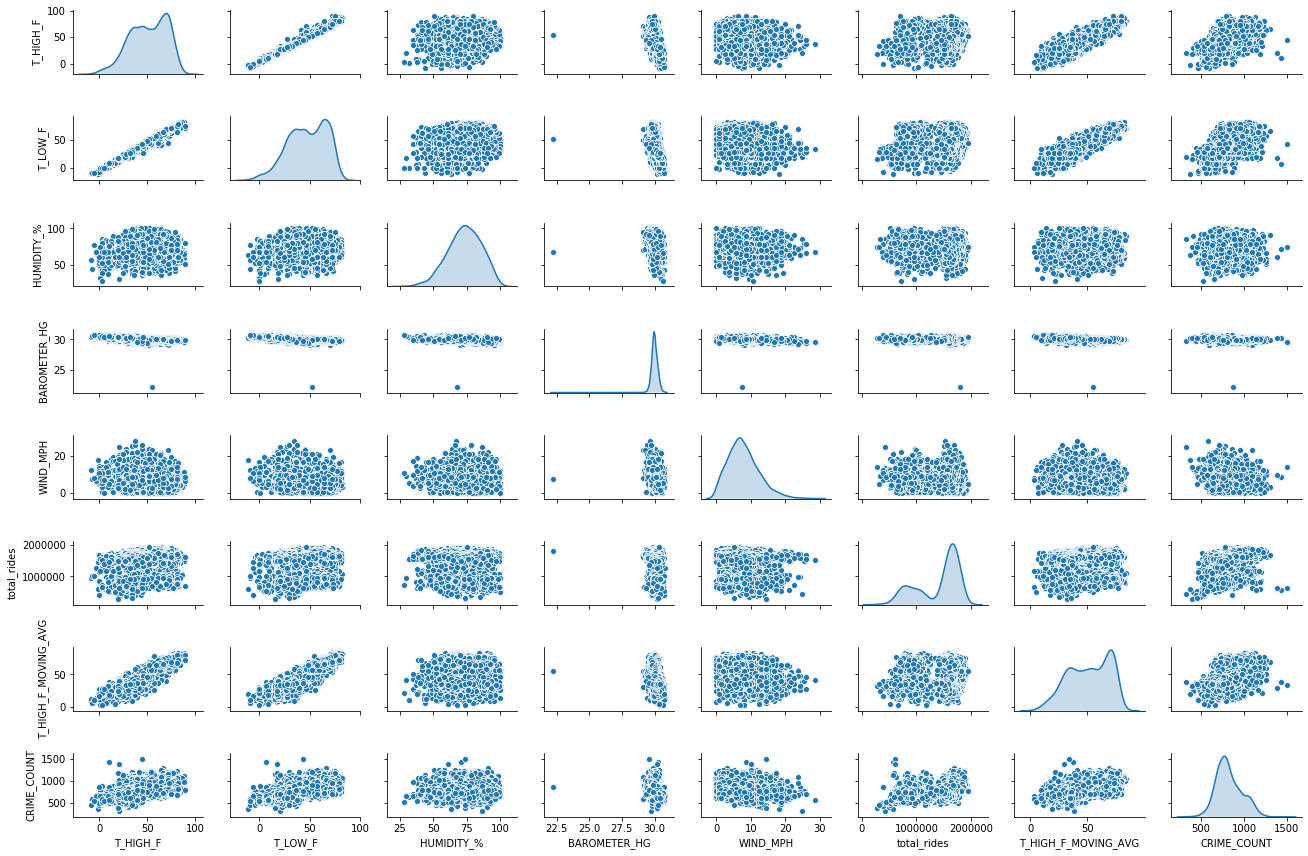

In [103]:
numerical_features = ['T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH','total_rides','T_HIGH_F_MOVING_AVG','CRIME_COUNT']
sns.pairplot(df_merged[numerical_features],height=1.5, aspect=1.5, diag_kind='kde');

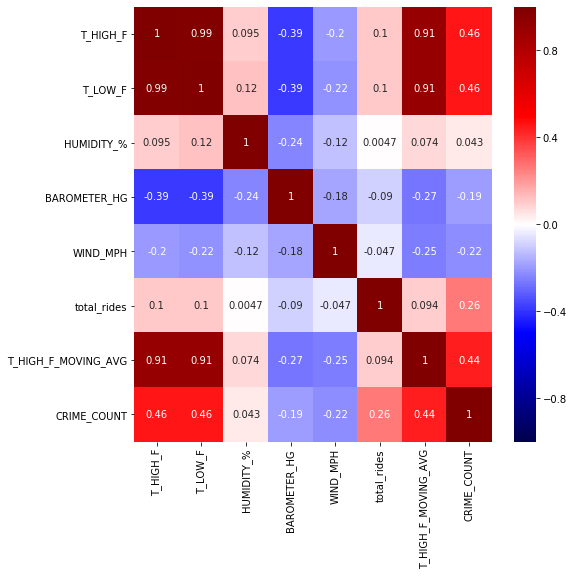

In [104]:
# corr matrix of numerical features
plt.figure(figsize=(8, 8))
sns.heatmap(df_merged[numerical_features].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

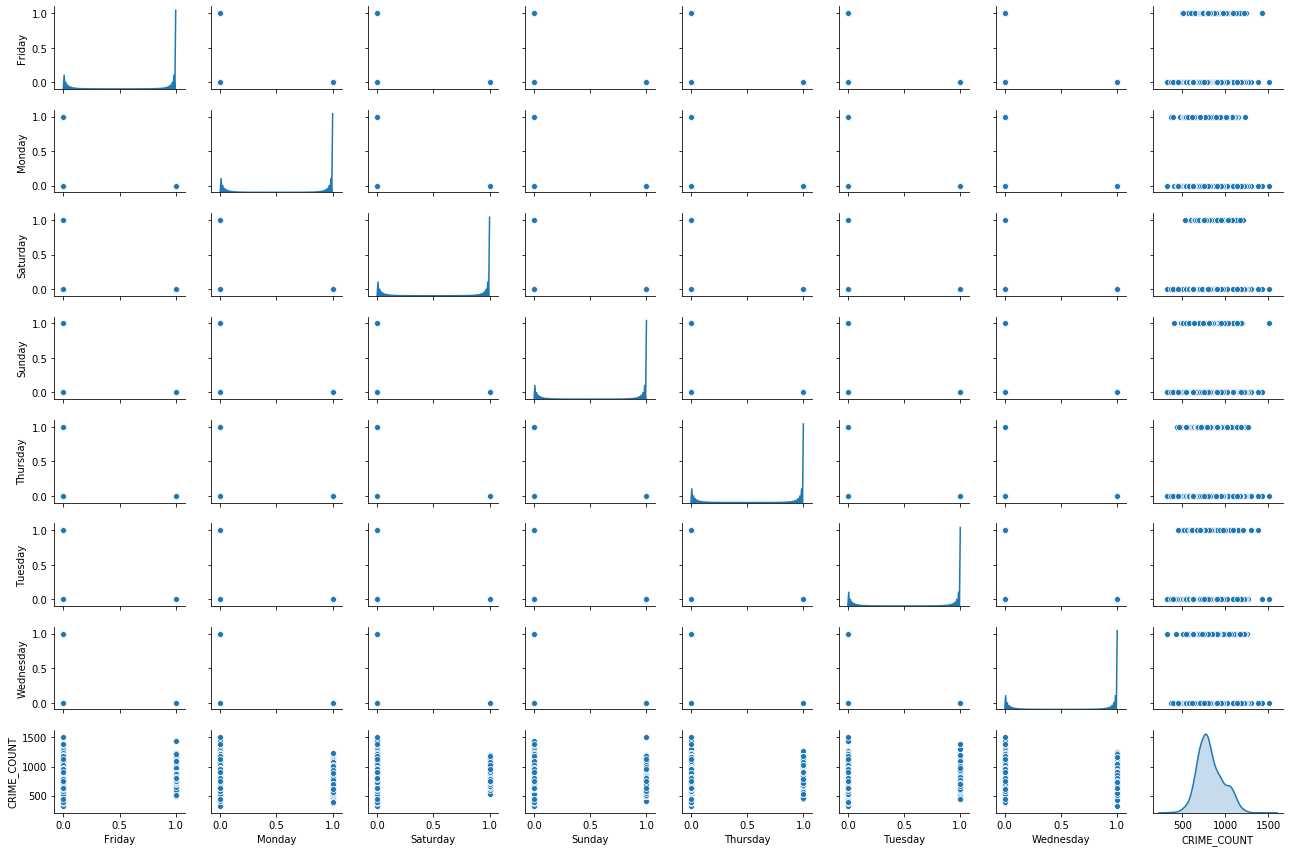

In [114]:
categorical_features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'April', 'August', 'December', 'February', 'January',
       'July', 'June', 'March', 'May', 'November', 'October', 'September',
       'Clear.', 'Fog.', 'Light rain. Fog.', 'Mostly cloudy.', 'Other',
       'Overcast.', 'Passing clouds.','CRIME_COUNT']
categorical_features_day_name = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday','CRIME_COUNT']
sns.pairplot(df_merged[categorical_features_day_name],height=1.5, aspect=1.5, diag_kind='kde');

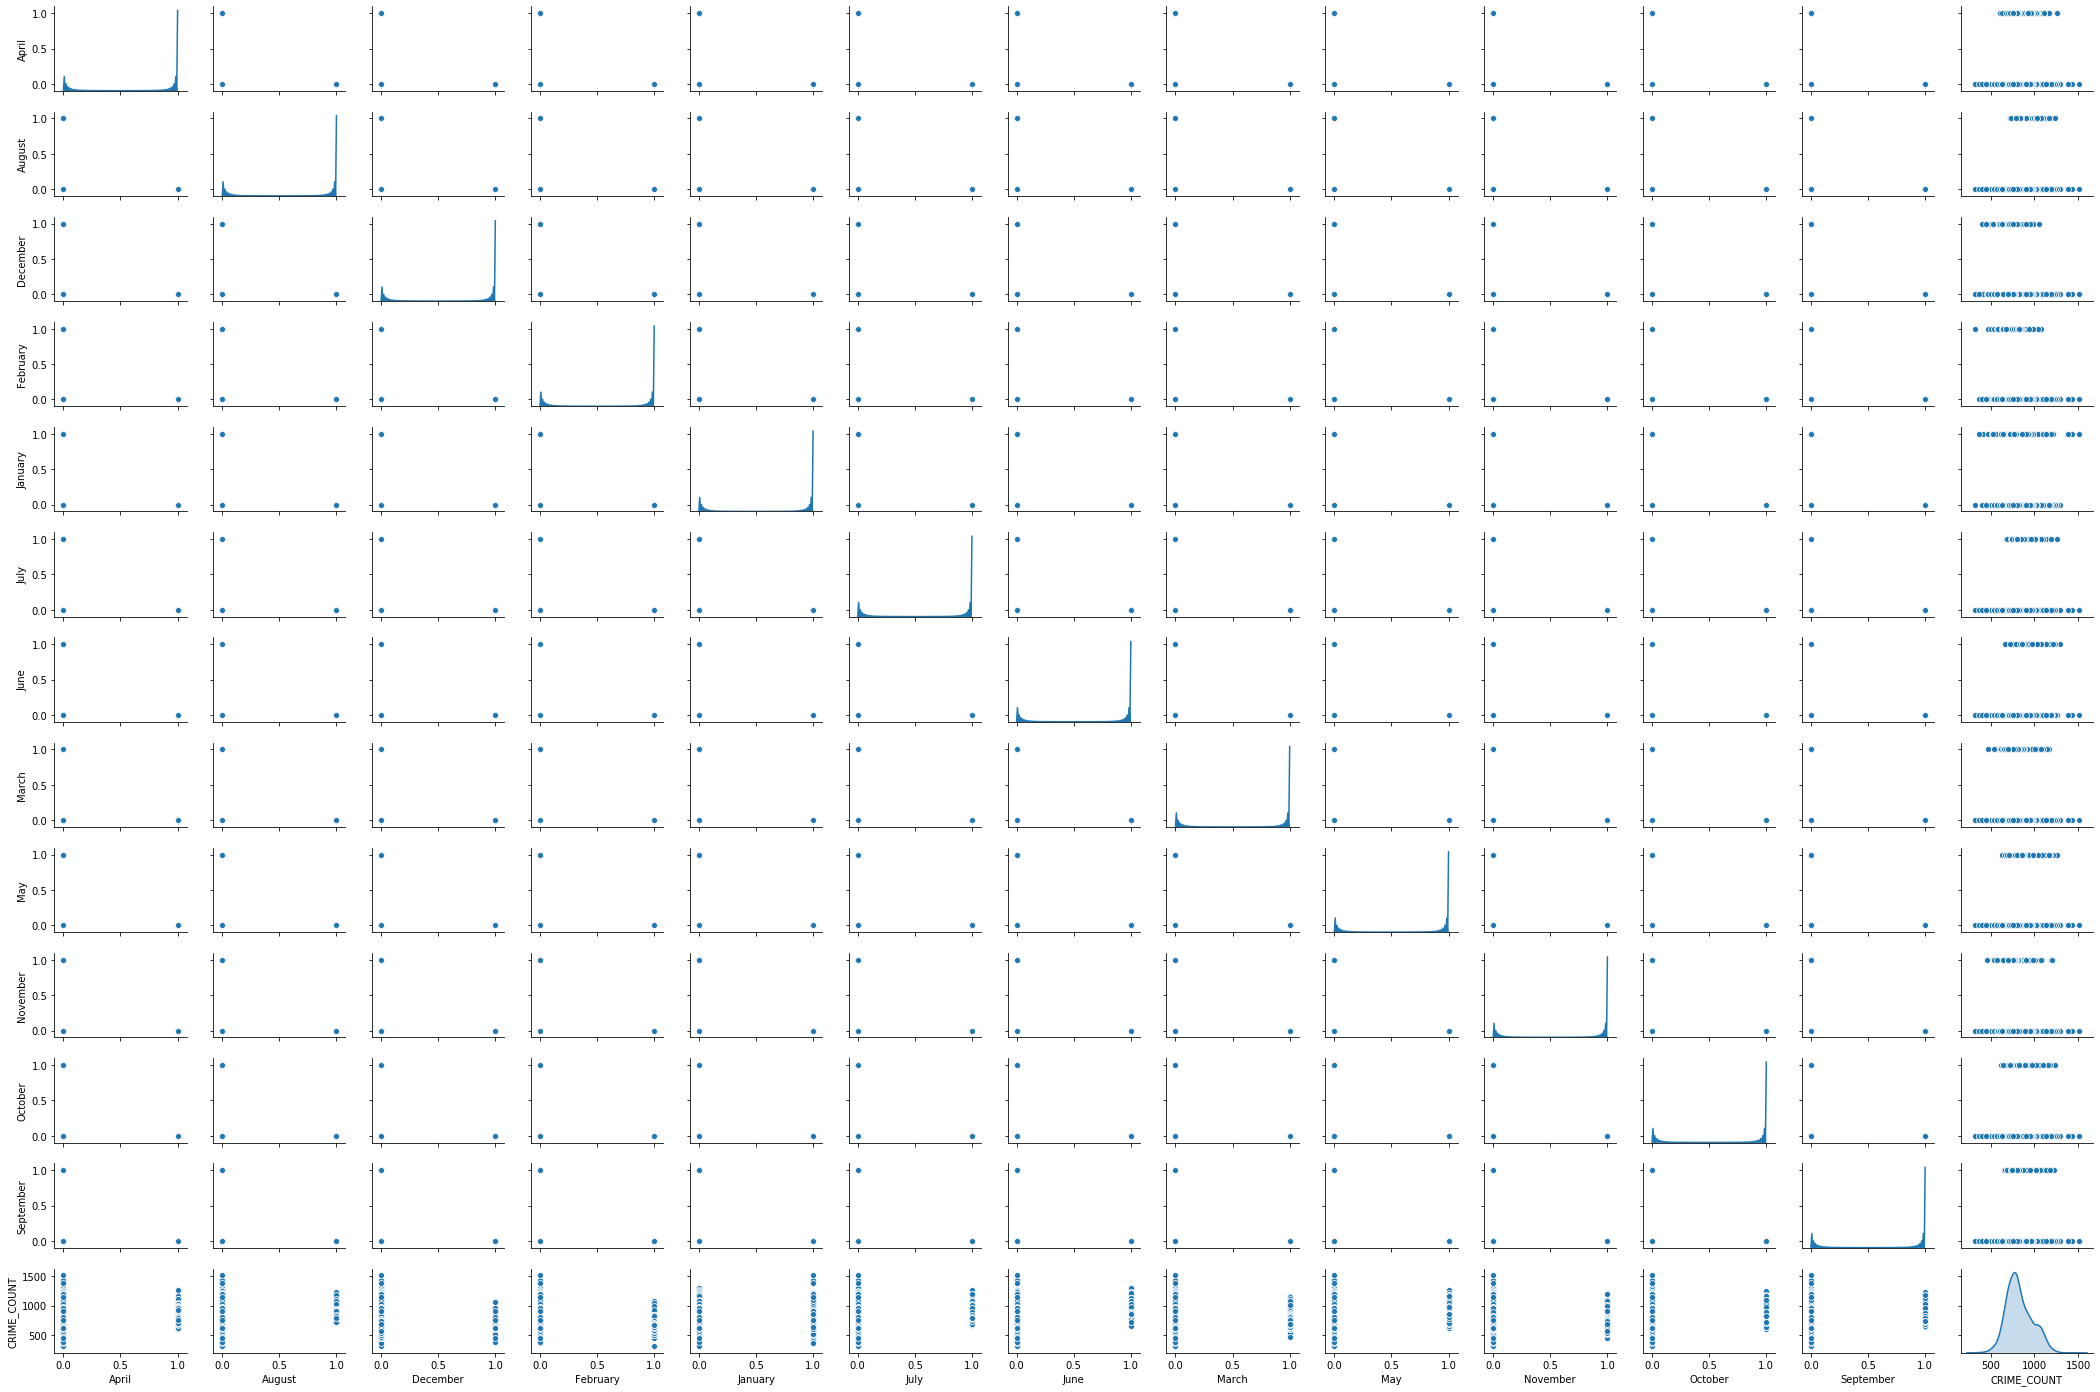

In [115]:
categorical_features_month = ['April', 'August', 'December', 'February', 'January',
       'July', 'June', 'March', 'May', 'November', 'October', 'September','CRIME_COUNT']
sns.pairplot(df_merged[categorical_features_month],height=1.5, aspect=1.5, diag_kind='kde');

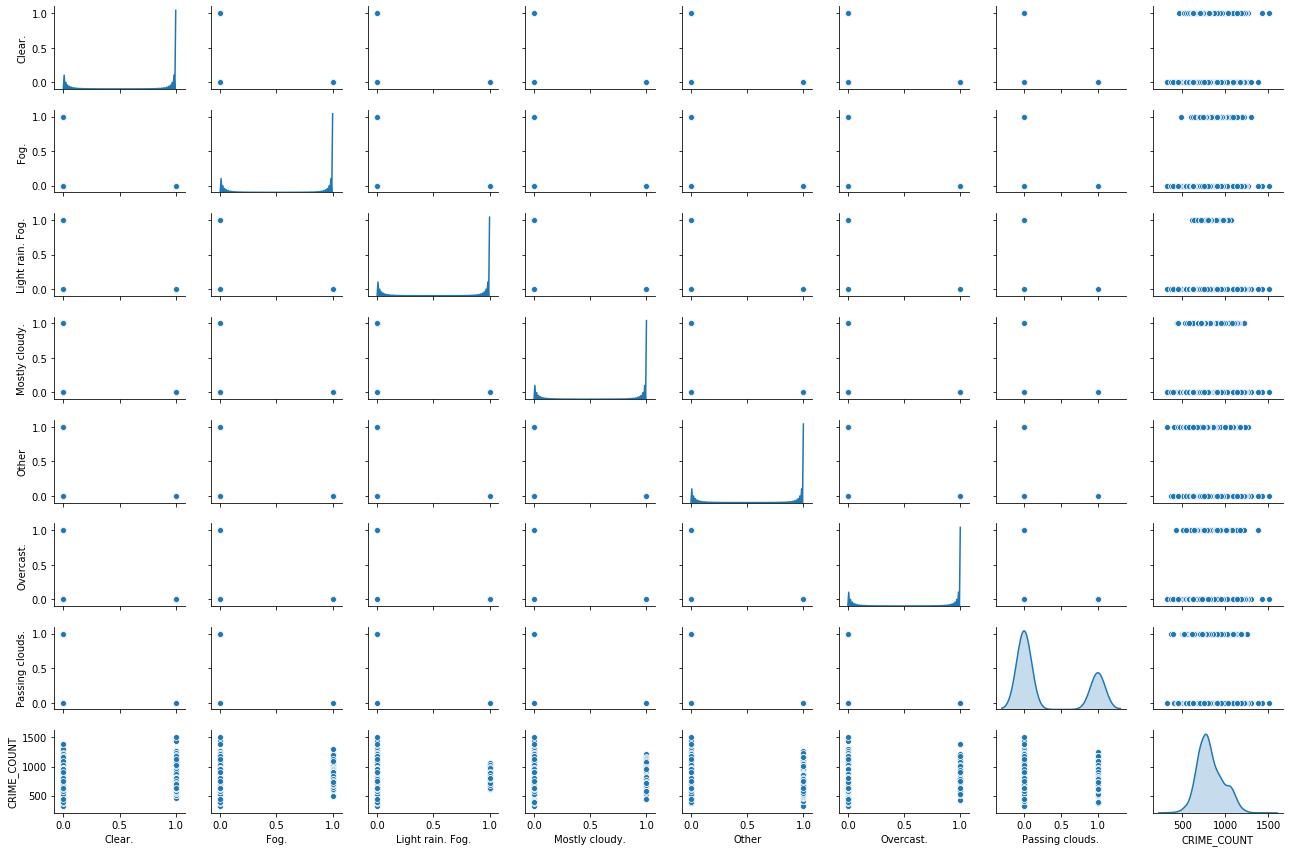

In [116]:
categorical_features_weather = ['Clear.', 'Fog.', 'Light rain. Fog.', 'Mostly cloudy.', 'Other',
       'Overcast.', 'Passing clouds.','CRIME_COUNT']
sns.pairplot(df_merged[categorical_features_weather],height=1.5, aspect=1.5, diag_kind='kde');

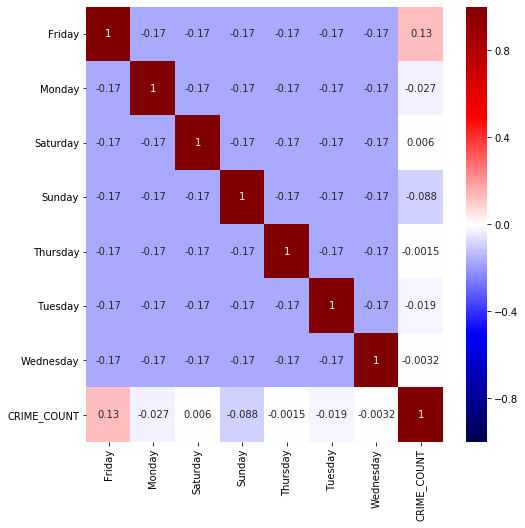

In [119]:
# corr matrix
plt.figure(figsize=(8, 8))
sns.heatmap(df_merged[categorical_features_day_name].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

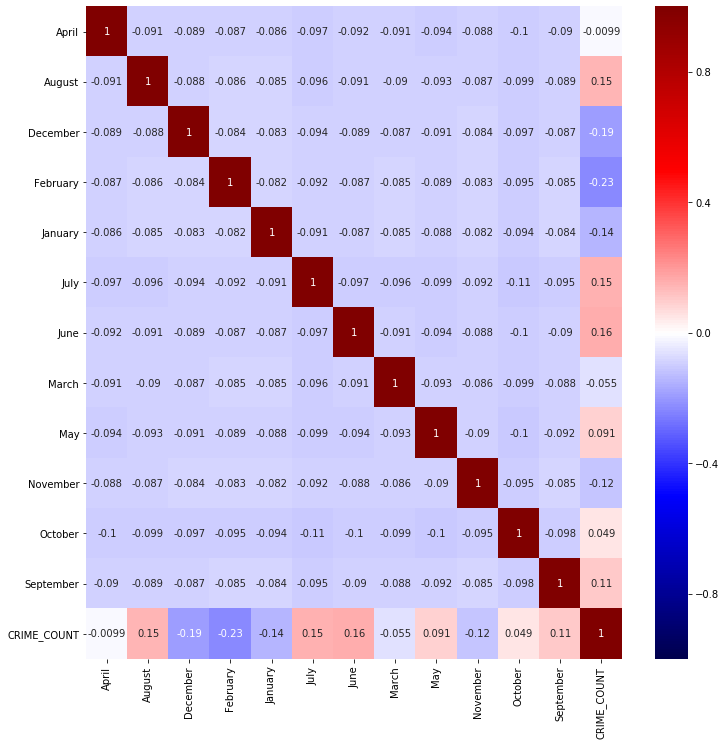

In [122]:
# corr matrix
plt.figure(figsize=(12,12))
sns.heatmap(df_merged[categorical_features_month].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

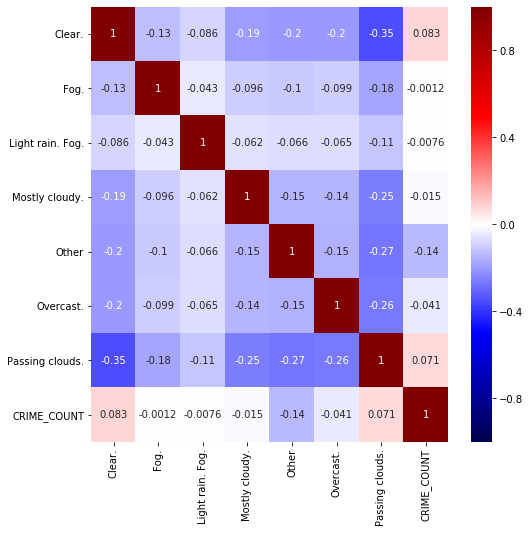

In [124]:
# corr matrix
plt.figure(figsize=(8,8))
sns.heatmap(df_merged[categorical_features_weather].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

# Add economical factors (income, job#, ...)
# Add population density
# ...
[Factors from FBI](https://ucr.fbi.gov/hate-crime/2011/resources/variables-affecting-crime)

[Chicago Turnstile](https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f)  
[Chicago Bus and Rail](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97)  
[Traffic Congestion](https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/77hq-huss)  
[Unemployment & Various Monthly Data](https://www.bls.gov/regions/midwest/il_chicago_msa.htm)

# Linear Regression

**LASSO**:
* _Pro_: great for trimming features and focusing interpretation on a few key ones
* _Con_: risk of discarding features that are actually useful
* 'l1_ratio' = 1 in ElasticNet

**Ridge**:
* _Pro_: great for smoothly handling multicollinearity, very nice when working with sparse features 
* _Con_: will never fully discard features
* 'l1_ratio' = 0 in ElasticNet


#### Graph Functions

In [89]:
def graph_pred_vs_actual(actual,pred,data_type):
    plt.scatter(actual,pred,alpha=.3)
    plt.plot(np.linspace(int(min(pred)),int(max(pred)),int(max(pred))),np.linspace(int(min(pred)),int(max(pred)),int(max(pred))))
    plt.title('Actual vs Pred ({} Data)'.format(data_type))
    plt.xlabel('Actual')
    plt.ylabel('Pred')  
    plt.show()
def graph_residual(actual,residual,data_type):
    plt.scatter(actual,residual,alpha=.3)
    plt.plot(np.linspace(int(min(actual)),int(max(actual)),int(max(actual))),np.linspace(0,0,int(max(actual))))
    plt.title('Actual vs Residual ({} Data)'.format(data_type))
    plt.xlabel('Actual')
    plt.ylabel('Residual')
    plt.show()
        

#### Remove 6 Outlier Points from Target

In [153]:
mask = ((df_merged['CRIME_COUNT']<df_merged['CRIME_COUNT'].quantile(0.999))
        &        
        (df_merged['CRIME_COUNT']>df_merged['CRIME_COUNT'].quantile(0.001)))
print(len(df_merged)-len(df_merged[mask]),"Rows Removed")
df_merged = df_merged[mask].copy()

6 Rows Removed


#### Split Data

In [154]:
features_all = list(df_merged.columns)
features_all.remove('CRIME_COUNT')

X = df_merged[features_all]
y = df_merged['CRIME_COUNT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,random_state = 42)

#### Remove Outliners for Numerical Features ('T_HIGH_F',  'T_LOW_F',  'HUMIDITY_%', 'BAROMETER_HG',  'WIND_MPH', 'total_rides') Based on Percentile (HURTS THE MODEL)

In [147]:
# features_base = list(df_merged.columns[0:7])
# features_base.remove('CRIME_COUNT')
# X_train_no_outlier = X_train.copy()
# X_train_no_outlier['CRIME_COUNT'] = y_train.copy()

# for ix,feature in enumerate(features_base):
#     mask = ((X_train_no_outlier[feature]<X_train_no_outlier[feature].quantile(0.98))
#             &        
#             (X_train_no_outlier[feature]>X_train_no_outlier[feature].quantile(0.02)))
#     X_train_no_outlier = X_train_no_outlier[mask].copy()
# print("Total Rows of Data Removed : ",len(X_train)-len(X_train_no_outlier))

# y_train = X_train_no_outlier['CRIME_COUNT'].copy()
# X_train = X_train_no_outlier.drop(columns=['CRIME_COUNT']).copy()


Total Rows of Data Removed :  636


#### Base Model

In [155]:
#Split the data 80/20 cross-validation/test
# Include Categorical features : ['T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH','total_rides']
features_base = list(df_merged.columns[0:7])
features_base.remove('CRIME_COUNT')

base_model = LinearRegression()
base_model.fit(X_train[features_base],y_train)

base_r2_train = base_model.score(X_train[features_base],y_train)
base_r2_test = base_model.score(X_test[features_base],y_test)
base_coef = list(zip(X_train[features_base].columns,base_model.coef_))

In [156]:
#Base_R^2_Train :  0.2546924527867718 and Base_R^2_Test :  0.3337184672866654 before moving outlier
print("Base Model")
print("\nBase_R^2_Train : ",base_r2_train)
print("Base_R^2_Test : ",base_r2_test)
print("\nCoefficients : ")
for row in base_coef:
    print(row)

Base Model

Base_R^2_Train :  0.2695889408354555
Base_R^2_Test :  0.32653078032859706

Coefficients : 
('T_HIGH_F', 2.9500650955713237)
('T_LOW_F', -0.010555924029876361)
('HUMIDITY_%', -0.29147155909752864)
('BAROMETER_HG', -22.05907184276823)
('WIND_MPH', -4.815048940771674)
('total_rides', 8.473092906921861e-05)


#### Graphs for Base Model

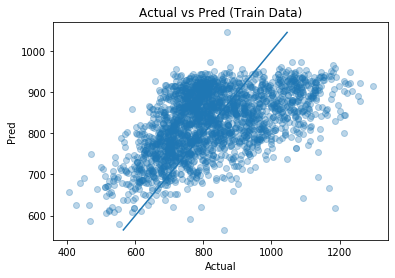

In [160]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_train,base_model.predict(X_train[features_base]),'Train')

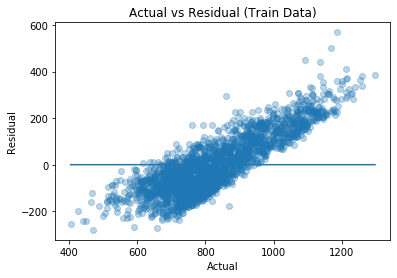

In [161]:
## Residual Plot
graph_residual(y_train,y_train-base_model.predict(X_train[features_base]),'Train')

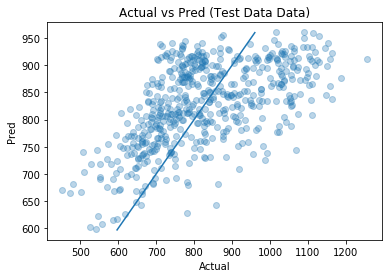

In [162]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,base_model.predict(X_test[features_base]),'Test Data')

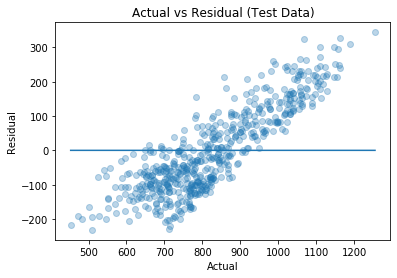

In [163]:
## Residual Plot
graph_residual(y_test,y_test-base_model.predict(X_test[features_base]),'Test')

#### ElasticNet - RandomGrid - All Features

In [167]:
#Split the data 80/20 cross-validation/test
features_all = list(df_merged.columns)
features_all.remove('CRIME_COUNT')

# Define cross-validation pipelines for lasso and ridge linear regression models
elasticnet_pipeline = Pipeline([
                        ('polynomial',PolynomialFeatures()),
                        ('standard',StandardScaler()),                        
                        ('model',ElasticNet())
                        ])

# # print parameters for lasso & ridge cross-validation pipelines
# print('ElasticNet Params :\n\n',elasticnet_pipeline.get_params().keys(),'\n')

#Define hyperparameters for GridSearchCV & RandomizedSearchCV
alphavec = 10**np.linspace(-2,2,300)
l1vec = np.linspace(0,1,100)
hyperparameters = {'polynomial__degree':[2],
                   'model__alpha':alphavec,
                   'model__l1_ratio':l1vec,
                   'model__max_iter':[2000],
                   #'model__normalize':[True,False],
                   'model__random_state':[209]}
clf_elastic_rand_grid = RandomizedSearchCV(elasticnet_pipeline,
                             param_distributions=hyperparameters,
                             cv=5,
                             random_state=209,
                             scoring='r2',
                             verbose=0)
clf_elastic_rand_grid.fit(X_train[features_all],y_train);

/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95498.82922244072, tolerance: 3878.0560839865625
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95686.34407688677, tolerance: 3838.6528016237403
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40847.47929114103, tolerance: 3830.107795352744
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: Conv

In [168]:
# R^2 Scores
# R^2 Score (Train Data):  0.5260655537526424 and R^2 Score (Test Data):  0.44061062222772496 before removing outliers
print("RandomizedSearchCV")
print("\nR^2 Score (Train Data): ",clf_elastic_rand_grid.score(X_train[features_all],y_train))
print("R^2 Score (Test Data): ",clf_elastic_rand_grid.score(X_test[features_all],y_test))
print("\nBest params : ",clf_elastic_rand_grid.best_params_)

RandomizedSearchCV

R^2 Score (Train Data):  0.5333786059737422
R^2 Score (Test Data):  0.4393637438450646

Best params :  {'polynomial__degree': 2, 'model__random_state': 209, 'model__max_iter': 2000, 'model__l1_ratio': 0.9595959595959597, 'model__alpha': 0.010635449574860113}


In [169]:
# Print All Coefficients

# Convert 'x0','x1',.... 'xn' to actual feature names
dict_coeff = dict()
for ix,feature in enumerate(features_all):
    coef = 'x'+str(ix)
    dict_coeff[coef] = feature
elasticnet_coef = clf_elastic_rand_grid.best_estimator_.named_steps.polynomial.get_feature_names()
for ix,coef in enumerate(elasticnet_coef):
    for jx,feature in enumerate(list(dict_coeff.keys())[::-1]):
        elasticnet_coef[ix] = elasticnet_coef[ix].replace(feature,dict_coeff[feature])

print("\nCoefficients : ")
for coeff in list(zip(elasticnet_coef,clf_elastic_rand_grid.best_estimator_.named_steps.model.coef_)):
    print(coeff)


Coefficients : 
('1', 0.0)
('T_HIGH_F', 52.40928737540688)
('T_LOW_F', 32.65504997434478)
('HUMIDITY_%', 18.388482961116168)
('BAROMETER_HG', 52.58442322693556)
('WIND_MPH', 37.99357872561531)
('total_rides', -77.41311216986014)
('T_HIGH_F_MOVING_AVG', 79.34693859681954)
('Friday', 8.355598851832367)
('Monday', 10.885167906165638)
('Saturday', -14.180533486605393)
('Sunday', -17.263539668703487)
('Thursday', 2.8721761311695864)
('Tuesday', -2.501010811649826)
('Wednesday', -0.0)
('April', -6.426290584251136)
('August', -18.618732545265082)
('December', 12.279530849137048)
('February', -4.911516939829145)
('January', 21.01688922429642)
('July', -16.642807309155952)
('June', -11.9468076724607)
('March', -5.676037579707727)
('May', 0.0)
('November', 6.11955427700833)
('October', 0.0)
('September', 10.346245277085476)
('Clear.', -3.056006940345364)
('Fog.', 3.3311179564752535)
('Light rain. Fog.', 4.413940704451313)
('Mostly cloudy.', -0.0)
('Other', 0.0)
('Overcast.', -7.443611178744458)

#### Graphs for ElasticNet Model

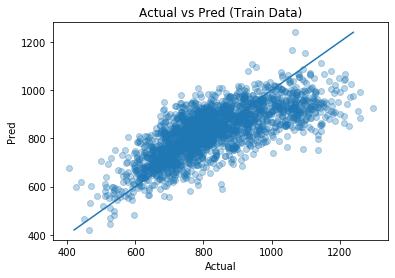

In [170]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_train,clf_elastic_rand_grid.predict(X_train[features_all]),'Train')

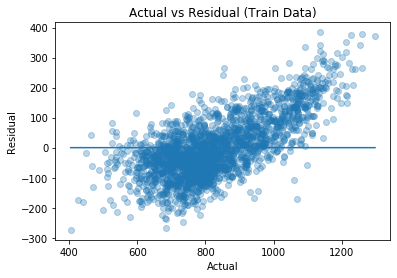

In [171]:
## Residual Plot
graph_residual(y_train,y_train-clf_elastic_rand_grid.predict(X_train[features_all]),'Train')

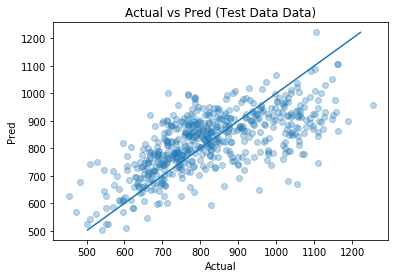

In [172]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,clf_elastic_rand_grid.predict(X_test[features_all]),'Test Data')

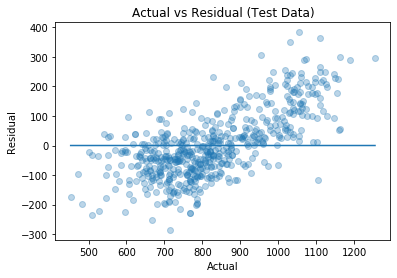

In [173]:
## Residual Plot
graph_residual(y_test,y_test-clf_elastic_rand_grid.predict(X_test[features_all]),'Test')